# Bibliotecas

In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np

#KS test, ji-cuadrada
from scipy.stats import ks_2samp, chi2_contingency

#Graficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Valores atipicos
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.mcd import MCD

#Valores ausentes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Cargar Dataset

In [2]:
def ruta(folder, file, user='Wsm-erick', main='Diplomado-Ciencia-de-Datos/refs/heads/main'):
    return os.path.join('https://raw.githubusercontent.com', user, main, folder, file)

In [3]:
url = ruta('Modulo-I/Datasets', 'wine_quality.csv')

df = pd.read_csv(url, encoding='utf-8')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,red
3,NaN,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,NaN
4,7.4,0.70,NaN,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,red


## 1.- Investiga a qué se refiere cada variable del conjunto de datos y sus valores normales de referencia.

Se encontró la siguiente informacion referente a los valores normales para cada una de las variables. Con base en esta informacion, se tomara la decision sobre el tratado de los valores atipicos que se lleguen a encontrar en la base.

In [4]:
url = ruta('Modulo-I/Datasets', 'Variables_del_vino.csv')

description = pd.read_csv(url, encoding='utf-8')
description

,Variable,Valor normal / típico,Descripción breve
0,fixed acidity,4.0 – 15.0 g/dm³ (tinto más ácido que blanco),Ácidos no volátiles como tartárico
1,volatile acidity,0.12 – 1.10 g/dm³,Ácidos volátiles (como el acético)
2,citric acid,0.0 – 1.0 g/dm³,Contribuye a frescura
3,residual sugar,0.6 – 65.0 g/dm³ (más en vinos blancos),Azúcar restante tras fermentación
4,chlorides,0.009 – 0.346 g/dm³,Indica presencia de sal
5,free sulfur dioxide,1 – 72 mg/dm³ (mayor en blancos),"SO₂ libre, protección antimicrobiana"
6,total sulfur dioxide,6 – 440 mg/dm³ (mayor en blancos),Total de SO₂ (libre + ligado)
7,density,0.9900 – 1.0040 g/cm³,Relacionado con azúcar y alcohol
8,pH,2.9 – 3.9,"Acidez, vinos blancos suelen tener pH más bajo"
9,sulphates,0.22 – 1.08 g/dm³,Estabilizador y conservante


In [5]:
valores_tipicos = {x: None for x in set(description['Variable'])-set({'type'})}

print(list(valores_tipicos.keys()))

['citric acid', 'total sulfur dioxide', 'quality', 'residual sugar', 'density', 'free sulfur dioxide', 'chlorides', 'pH', 'fixed acidity', 'sulphates', 'alcohol', 'volatile acidity']


In [6]:
valores_tipicos = {
    'fixed acidity': (4,15,'g/dm³'),
    'volatile acidity': (0.12,1.1,'g/dm³'),
    'citric acid': (0,1,'g/dm³'),
    'residual sugar': (0.6,65,'g/dm³'),
    'chlorides': (0.009,0.346,'g/dm³'),
    'free sulfur dioxide': (1,72,'mg/dm³'),
    'total sulfur dioxide': (6,440,'mg/dm³'),
    'density': (0.99,1.0040,'g/cm³'),
    'pH': (2.9,3.9,'-'),
    'sulphates': (0.22,1.08,'g/dm³'),
    'alcohol': (8,14.9,'vol'),
    'quality': (3,9,'-')
}

In [7]:
def f_tip(x: float, xmin: float, xmax: float):
  return 1 if x >= xmin and x <= xmax else 0

N = df.shape[0]
data = []
for x, (xmin, xmax, unidad) in valores_tipicos.items():
  n = df[x].apply(lambda y: f_tip(y, xmin, xmax)).sum()
  nulos = df[x].isna().sum()
  data.append([x, unidad, xmin, xmax, nulos, n, N-n-nulos])

df_val_atipicos = pd.DataFrame(data=data, columns=['Variable', 'Unidad', 'Límite Inf', 'Límite Sup', 'Valores Ausentes', 'Valores Típicos', 'Valores Atípicos'])
display(df_val_atipicos)

,Variable,Unidad,Límite Inf,Límite Sup,Valores Ausentes,Valores Típicos,Valores Atípicos
0,fixed acidity,g/dm³,4.000,15.000,995,5497,5
1,volatile acidity,g/dm³,0.120,1.100,949,5517,31
2,citric acid,g/dm³,0.000,1.000,454,6042,1
3,residual sugar,g/dm³,0.600,65.000,200,6296,1
4,chlorides,g/dm³,0.009,0.346,0,6479,18
5,free sulfur dioxide,mg/dm³,1.000,72.000,138,6267,92
6,total sulfur dioxide,mg/dm³,6.000,440.000,744,5753,0
7,density,g/cm³,0.990,1.004,0,6149,348
8,pH,-,2.900,3.900,180,6238,79
9,sulphates,g/dm³,0.220,1.080,626,5836,35


In [8]:
print("Valores atípicos con respecto a los valores normales de la variable:", df_val_atipicos['Valores Atípicos'].sum())

Valores atípicos con respecto a los valores normales de la variable: 610


## 2.- ¿Existen valores atípicos? ¿Valores ausentes?

Sí, como vemos en las celdas anteriores si hay valores ausentes y valores atípicos. A continuación vamos a revisar más a detalle los valores ausentes e imputaremos por el método de MICE los valores nulos para poder revisar los valores atípicos, cuando el dataset no contenga valores nulos.

In [9]:
var_cat = ["type"]
var_num = list(set(df.columns) - set(var_cat))

In [10]:
print('Variables categóricas:', var_cat[0],
    '\n\n'+'Variables numéricas:', ', '.join(var_num))

Variables categóricas: type 

Variables numéricas: citric acid, total sulfur dioxide, quality, residual sugar, density, free sulfur dioxide, chlorides, pH, fixed acidity, sulphates, alcohol, volatile acidity


In [11]:
def is_na_df(df):
    #Establecemos el resumen de NAs por columna
    na_summary = (
        df.isna().sum()
        .reset_index()
        .rename(columns={"index": "columna", 0: "n_missing"})
    )

    #Tomamos totales y prporciones
    na_summary["total"] = len(df)
    na_summary["prop_missing"] = na_summary["n_missing"] / na_summary["total"]
    na_summary["prop_original"] = 1 - na_summary["prop_missing"]

    #Filtramos solo columnas con al menos 1 NA
    na_summary = na_summary[na_summary["n_missing"] > 0].reset_index(drop=True)

    #Agregamos fila resumen global
    total_missing = df.isna().sum().sum()
    total_elements = df.size
    prop_missing_global = total_missing / total_elements
    prop_original_global = 1 - prop_missing_global

    resumen = pd.DataFrame({
        "columna": ["TOTAL"],
        "n_missing": [total_missing],
        "total": [total_elements],
        "prop_missing": [prop_missing_global],
        "prop_original": [prop_original_global]
    })

    #Creamos la tabla
    na_summary = pd.concat([na_summary, resumen], ignore_index=True)

    return na_summary

In [12]:
is_na_df(df)

,columna,n_missing,total,prop_missing,prop_original
0,fixed acidity,995,6497,0.153148,0.846852
1,volatile acidity,949,6497,0.146067,0.853933
2,citric acid,454,6497,0.069878,0.930122
3,residual sugar,200,6497,0.030783,0.969217
4,free sulfur dioxide,138,6497,0.021241,0.978759
5,total sulfur dioxide,744,6497,0.114514,0.885486
6,pH,180,6497,0.027705,0.972295
7,sulphates,626,6497,0.096352,0.903648
8,alcohol,183,6497,0.028167,0.971833
9,quality,591,6497,0.090965,0.909035


Obtenemos que 10 variables cuentan con valores ausentes. Se representa en la siguiente tabla el numero de valores ausentes por variable y la proporcion que representan.

Realizaremos dos metodos de imputacion con el fin de poder determinar cual es el mas conveniente en cuanto a la preservacion de las distribuciones.

### Imputación en cadena (MICE)

In [13]:
def evaluate_imputation(df_original, df_imputed, vars_num=None, vars_cat=None):
    resultados = []

    # KS test en variables numéricas
    if vars_num:
        for col in vars_num:
            orig = df_original[col].dropna()
            imp = df_imputed[col]
            stat, pval = ks_2samp(orig, imp)
            resultados.append({
                "Variable": col,
                "Tipo": "Numérica",
                "Prueba": "KS test",
                "Estadístico": stat,
                "p-value": pval
            })

    # Chi-cuadrada en variables categóricas
    if vars_cat:
        for col in vars_cat:
            orig_counts = df_original[col].value_counts(dropna=True, normalize=True)
            imp_counts = df_imputed[col].value_counts(normalize=True)

            categories = list(set(orig_counts.index) | set(imp_counts.index))
            observed = np.array([
                [orig_counts.get(cat, 0), imp_counts.get(cat, 0)]
                for cat in categories
            ])
            chi2, pval, _, _ = chi2_contingency(observed.T)
            resultados.append({
                "Variable": col,
                "Tipo": "Categórica",
                "Prueba": "Chi-cuadrada",
                "Estadístico": chi2,
                "p-value": pval
            })

    return pd.DataFrame(resultados)

In [14]:
def impute_mice(df, vars_num, vars_cat, random_state=1989, max_iter=1000):
    df_copy = df.copy()

    # Convertir categóricas a códigos numéricos temporales
    cat_maps = {}
    for col in vars_cat:
        df_copy[col] = df_copy[col].astype("category")
        cat_maps[col] = dict(enumerate(df_copy[col].cat.categories))
        df_copy[col] = df_copy[col].cat.codes.replace(-1, np.nan)

    # IterativeImputer trabaja sobre todo el DF
    imputer = IterativeImputer(random_state=random_state, max_iter=max_iter)
    imputed_array = imputer.fit_transform(df_copy)
    imputed_df = pd.DataFrame(imputed_array, columns=df_copy.columns, index=df_copy.index)

    # Redondear categóricas y devolver a etiquetas originales
    for col in vars_cat:
        imputed_df[col] = imputed_df[col].round().astype(int)
        imputed_df[col] = imputed_df[col].map(cat_maps[col])

    reporte = evaluate_imputation(df, imputed_df, vars_num, vars_cat)
    return imputed_df, reporte

In [15]:
micer = impute_mice(df, var_num, var_cat)

In [16]:
display(micer[0], micer[1])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.400000,0.700000,0.000000,1.900000,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.000000,red
1,7.800000,0.880000,0.000000,2.600000,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.000000,red
2,7.800000,0.760000,0.040000,2.300000,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.000000,red
3,10.178140,0.280000,0.560000,1.900000,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.000000,red
4,7.400000,0.700000,0.117625,1.900000,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.000000,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.371783,0.210000,0.290000,1.600000,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6.000000,white
6493,6.500478,0.320000,0.360000,8.000000,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5.000000,white
6494,6.500000,0.240000,0.190000,3.349322,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,5.485587,white
6495,5.500000,0.290672,0.300000,1.100000,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7.000000,white


,Variable,Tipo,Prueba,Estadístico,p-value
0,citric acid,Numérica,KS test,0.007881,0.988915
1,total sulfur dioxide,Numérica,KS test,0.010920,0.854591
2,quality,Numérica,KS test,0.029328,0.009508
3,residual sugar,Numérica,KS test,0.004566,1.000000
4,density,Numérica,KS test,0.000000,1.000000
5,free sulfur dioxide,Numérica,KS test,0.001406,1.000000
6,chlorides,Numérica,KS test,0.000000,1.000000
7,pH,Numérica,KS test,0.004205,1.000000
8,fixed acidity,Numérica,KS test,0.016022,0.423044
9,sulphates,Numérica,KS test,0.021906,0.101626


Realizando la prueba de KS obtenemos que la mayoría de las variables tienen un p-value mayor que 0.05 a excepecion de una, la variable quality. De igual manera, con este metodo de imputacion ya no presentamos ningun valor ausente.

Sin embargo, debido a que una variable no paso la prueba de KS, realizaremos otro metodo de imputacion con el fin de poder ver cual de los dos nos arroja mejores resultados.

In [17]:
is_na_df(micer[1])

,columna,n_missing,total,prop_missing,prop_original
0,TOTAL,0,65,0.0,1.0


In [18]:
imputed_df = micer[0]

In [19]:
imputed_df.describe(include = "all")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6494
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,white
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4897
mean,7.215580,0.340131,0.318424,5.443155,0.056034,30.528763,115.376127,0.994697,3.218443,0.531498,10.494635,5.816498,NaN
std,1.272535,0.158513,0.141323,4.749903,0.035034,17.639884,55.591614,0.002999,0.160206,0.145053,1.188895,0.844550,NaN
min,3.800000,-0.261265,-0.282880,-3.297837,0.009000,-0.813248,-19.857417,0.987110,2.720000,0.220000,8.000000,3.000000,NaN
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992340,3.110000,0.440000,9.500000,5.000000,NaN
50%,7.000000,0.295000,0.310000,3.100000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,NaN
75%,7.700000,0.410000,0.390000,8.100000,0.065000,41.000000,154.108606,0.996990,3.320000,0.600000,11.300000,6.000000,NaN


### Atípicos

In [20]:
class analyze:
    # Inicializamos la clase
    def __init__(self, df, num_vars, cat_vars):
        self.df = df
        self.num_vars = num_vars
        self.cat_vars = cat_vars

    #Método para graficar variables numéricas (cada una en figura independiente)
    def plot_num(self):
        for var in self.num_vars:
            fig = make_subplots(rows=1, cols=2, subplot_titles=(f"{var} - Boxplot", f"{var} - Histograma"))

            # Boxplot
            fig.add_trace(
                go.Box(y=self.df[var], name="Boxplot", marker_color="#008080"),
                row=1, col=1
            )

            # Histograma
            fig.add_trace(
                go.Histogram(x=self.df[var], name="Histograma",
                             marker_color="#00a77d", nbinsx=50,
                             histnorm='probability density'),
                row=1, col=2
            )

            fig.update_layout(title_text=f"Variable numérica: {var}", height=400, width=800)
            fig.show()

    #Método para graficar variables categóricas
    def plot_cat(self):
        n = len(self.cat_vars)
        cols = 2
        rows = (n + 1) // cols if n > 1 else 1

        fig = make_subplots(
            rows=rows, cols=cols,
            specs=[[{'type':'domain'}]*cols for _ in range(rows)],
            subplot_titles=self.cat_vars
        )

        for i, var in enumerate(self.cat_vars):
            row = i // cols + 1
            col = i % cols + 1

            value_counts = self.df[var].value_counts()
            labels = value_counts.index.astype(str)
            values = value_counts.values

            fig.add_trace(
                go.Pie(labels=labels, values=values, name=var, textinfo='percent+label'),
                row=row, col=col
            )

        fig.update_layout(title_text="Variables Categóricas", height=400*rows)
        fig.show()

    #Método para graficar la matriz de correlación de numéricas
    def corr_matrix(self):
        corr_matrix = self.df[self.num_vars].corr()

        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale='Viridis'))

        fig.update_layout(
            title='Matriz de Correlación',
            width=800,
            height=600
        )

        fig.show()

In [21]:
analisis = analyze(imputed_df, var_num, var_cat)

Exploración de distribución de cada variable para la detección de valores atípicos (primer acercamiento).

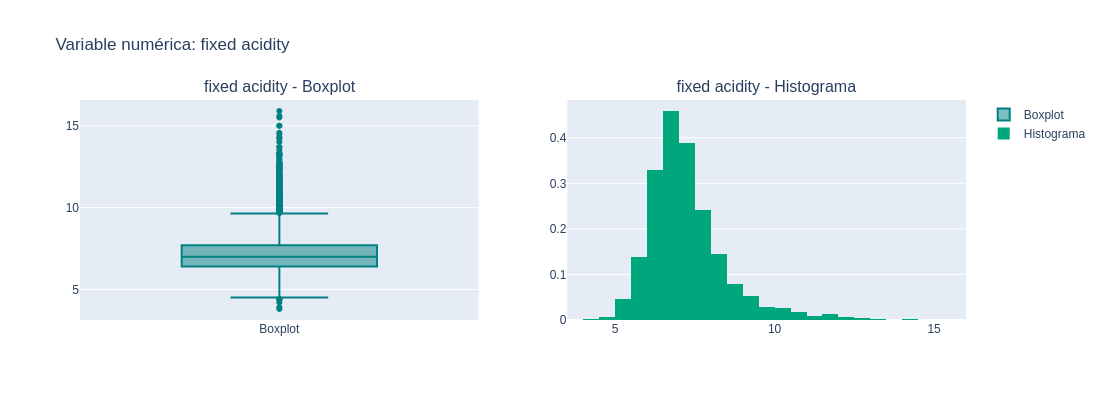

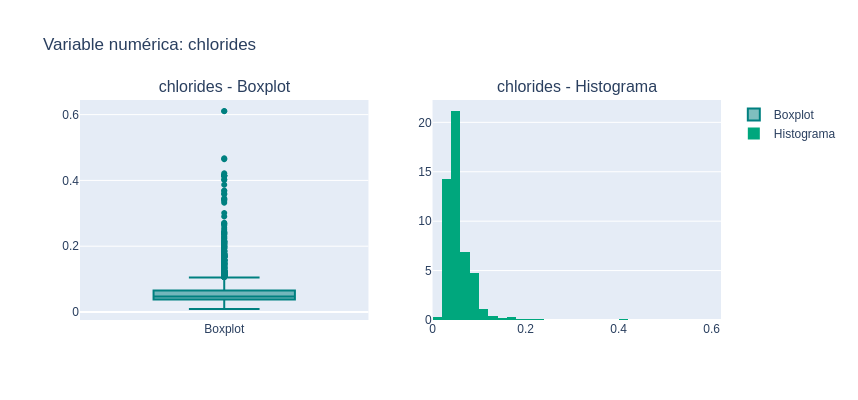

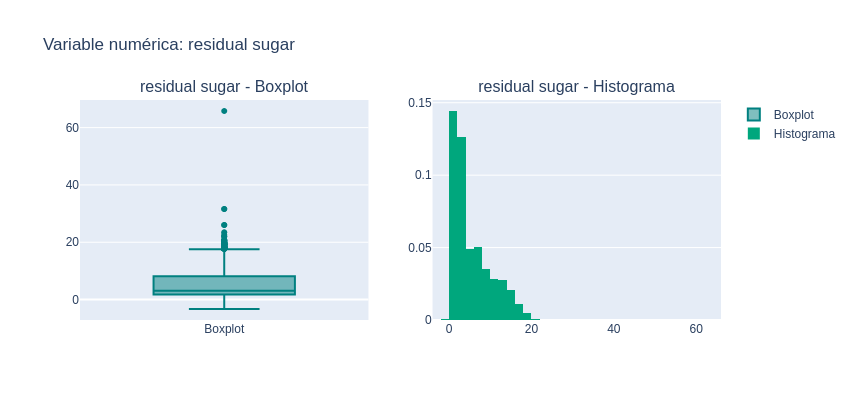

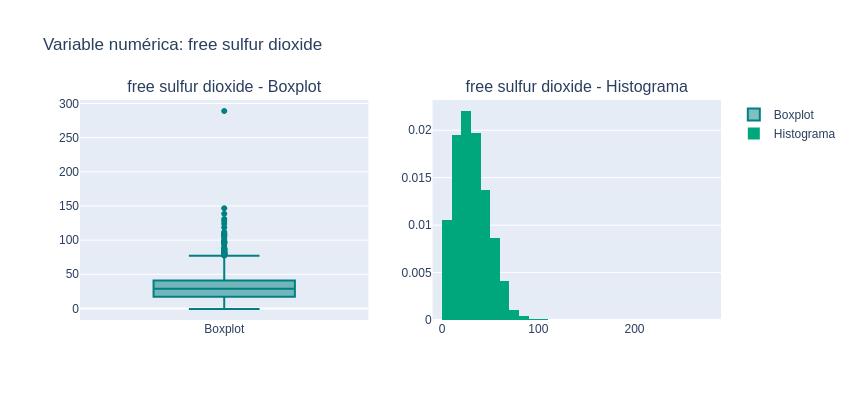

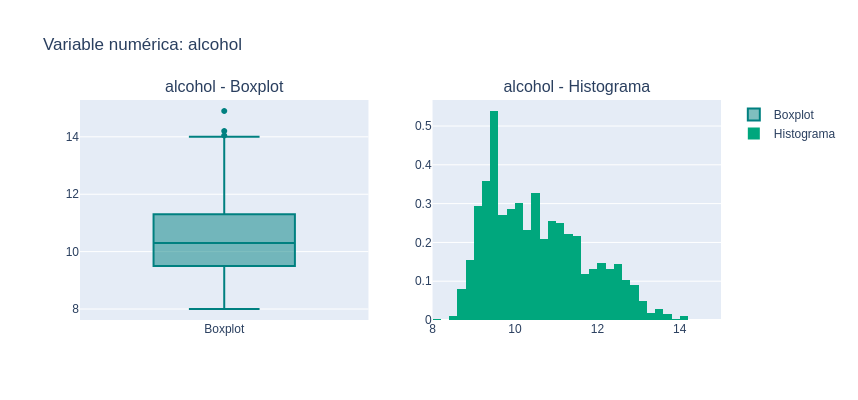

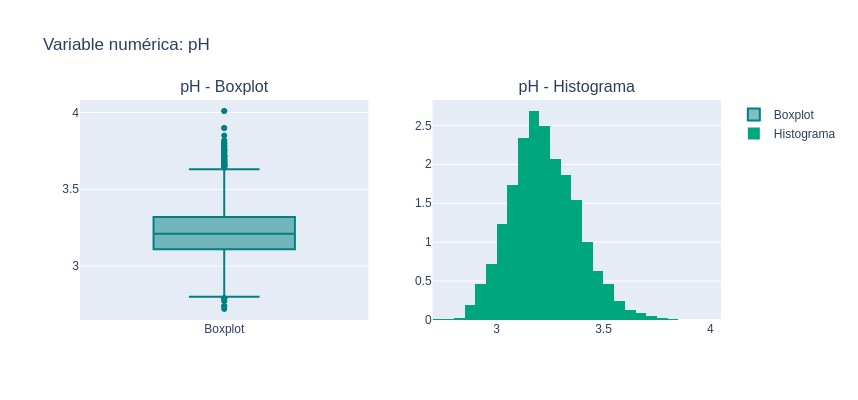

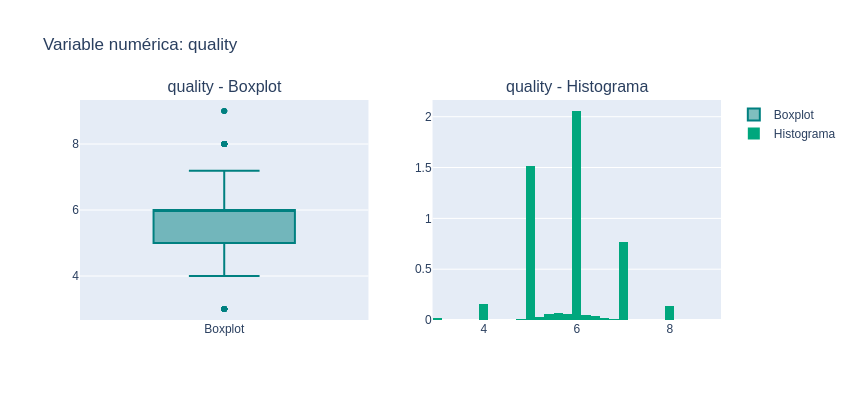

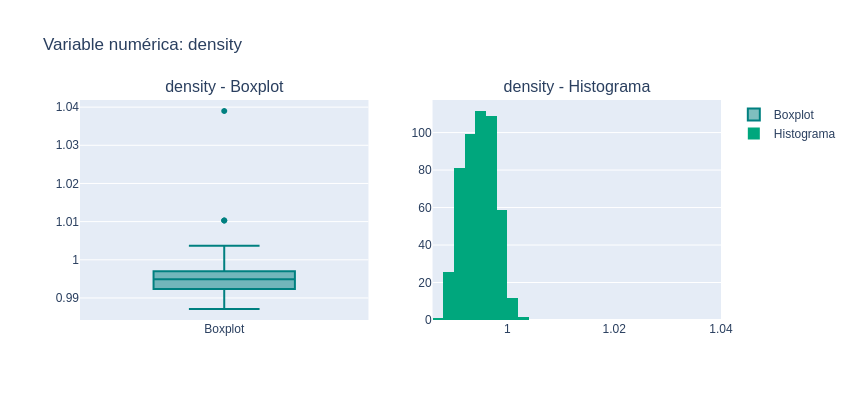

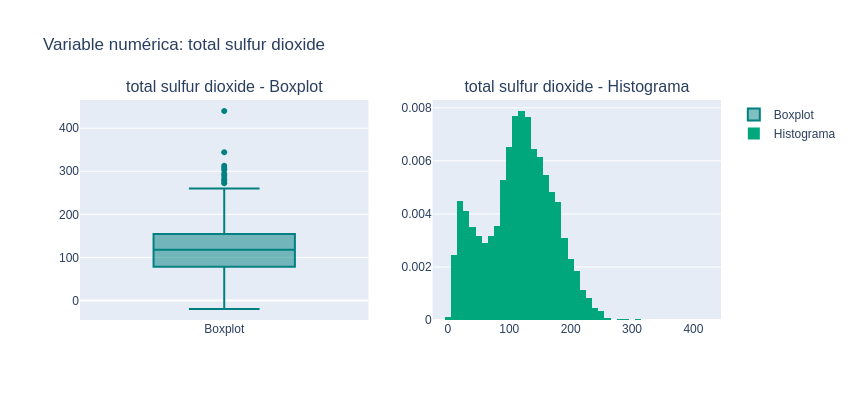

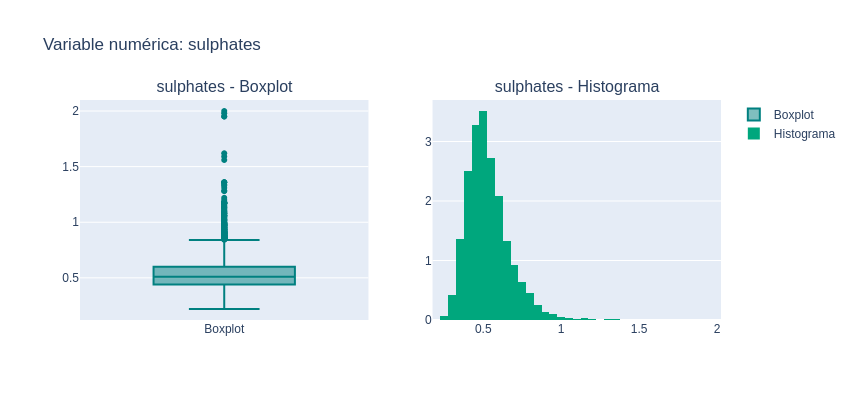

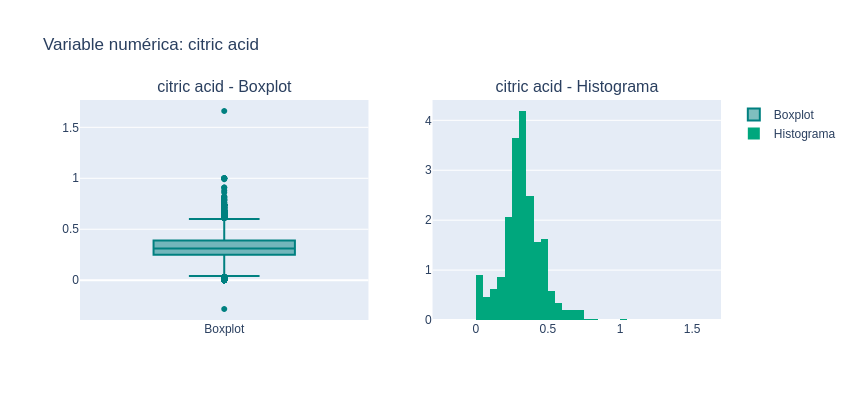

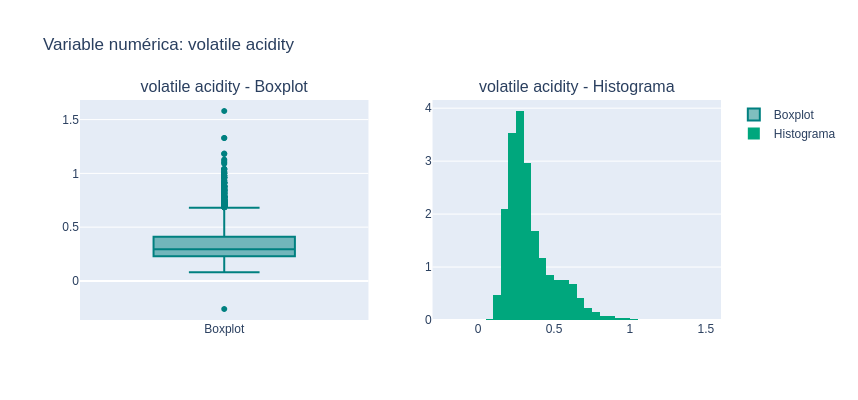

In [54]:
analisis.plot_num()

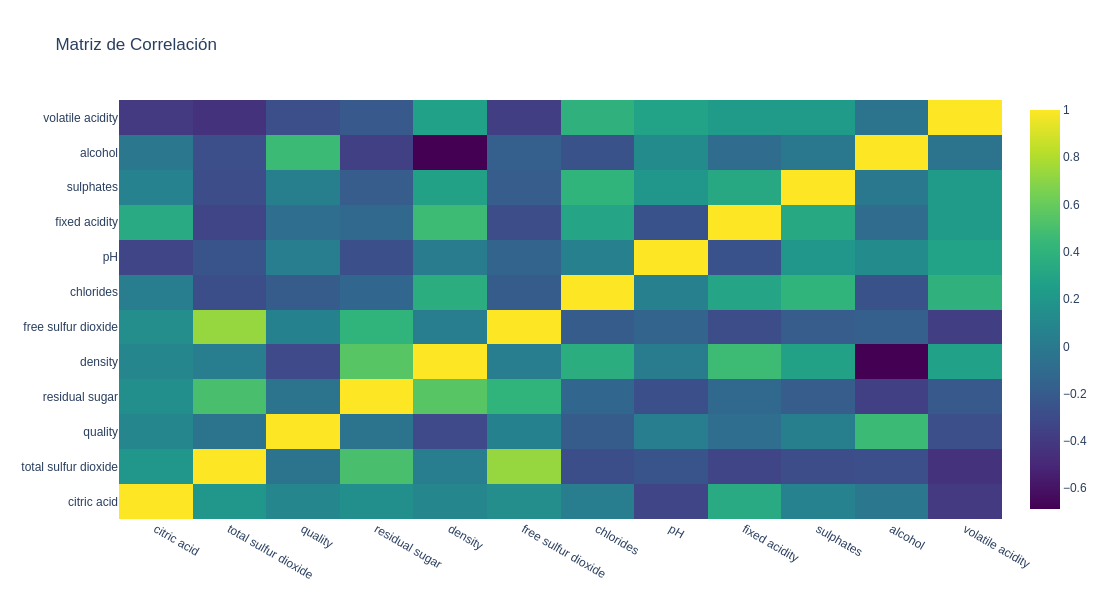

In [22]:
analisis.corr_matrix()

### Valores Atípicos

In [23]:
df_val_atipicos[['Variable', 'Unidad', 'Límite Inf', 'Límite Sup', 'Valores Atípicos']]

,Variable,Unidad,Límite Inf,Límite Sup,Valores Atípicos
0,fixed acidity,g/dm³,4.000,15.000,5
1,volatile acidity,g/dm³,0.120,1.100,31
2,citric acid,g/dm³,0.000,1.000,1
3,residual sugar,g/dm³,0.600,65.000,1
4,chlorides,g/dm³,0.009,0.346,18
5,free sulfur dioxide,mg/dm³,1.000,72.000,92
6,total sulfur dioxide,mg/dm³,6.000,440.000,0
7,density,g/cm³,0.990,1.004,348
8,pH,-,2.900,3.900,79
9,sulphates,g/dm³,0.220,1.080,35


**Variable Chlorides**

Aunque en el gráfico de boxplot de la variable chlorides pareciera que hay muchos puntos atípicos, si tomamos en cuenta el rango normal de la variable (valores entre 0.009 y 0.346), en realidad solo se identifican 18 valores fuera de este rango, lo cual es un número reducido en comparación con lo que sugiere el gráfico.

In [24]:
print("Valores atípicos en la variable chlorides:", imputed_df[(imputed_df['chlorides'] < 0.009) | (imputed_df['chlorides'] > 0.346)].shape[0])

Valores atípicos en la variable chlorides: 18


**Variable Density**

In [25]:
print("Valores atípicos en la variable density:", imputed_df[(imputed_df['density'] < 0.99) | (imputed_df['density'] > 1.004)].shape[0])

Valores atípicos en la variable density: 348


In [26]:
percentiles = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100]

valores = np.percentile(imputed_df['density'], percentiles)

percentiles_df = pd.DataFrame(data = [valores], columns = percentiles)

display(percentiles_df)

,0,1,5,10,20,30,40,50,60,70,80,90,95,99,100
0,0.98711,0.98892,0.9899,0.99067,0.9918,0.9928,0.9938,0.99489,0.99568,0.99655,0.9974,0.9984,0.999392,1.0006,1.03898


In [27]:
percentiles = np.arange(5, 10.5, 0.5)  # incluimos 10

valores = np.percentile(imputed_df['density'], percentiles)

percentiles_df = pd.DataFrame(data = [valores], columns = percentiles)

display(percentiles_df)

,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
0,0.9899,0.99,0.990078,0.990182,0.99022,0.99031,0.9904,0.990472,0.99058,0.9906,0.99067


Vemos que un 5.5% de la muestra se acumula por debajo del valor mínimo esperado, 345 de los 348 valores atípicos observados anteriormente, el resto son valores mayores a 1.004.

In [28]:
imputed_df[imputed_df['density'] < np.percentile(imputed_df['density'], 5.5)].shape[0]

345

Density es la variable con más valores atípicos, sin embargo, tomando en cuenta que los valores por debajo del valor mínimo esperado se encuentran cerca de éste, entonces más adelante podemos considerar si los mantenemos como parte de la muestra.

**Detección de outliers**

In [29]:
#Detectar
def detect_outliers_iforest(df, n_estimators=100, contamination=0.01, random_state=1989):
    model = IForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)
    model.fit(df.values)
    preds = model.predict(df.values)
    return df[preds == 1]

In [30]:
df_outliers = detect_outliers_iforest(imputed_df[var_num])

In [31]:
N = imputed_df.shape[0] # Filas del dataframe original

In [32]:
n_outliers = df_outliers.shape[0] # Outliers

In [33]:
prop = n_outliers / N
print(f"Proporción de valores atípicos: {prop:.6%}")

Proporción de valores atípicos: 1.000462%


In [34]:
df_val_atipicos[['Variable', 'Unidad', 'Límite Inf', 'Límite Sup', 'Valores Atípicos']]

,Variable,Unidad,Límite Inf,Límite Sup,Valores Atípicos
0,fixed acidity,g/dm³,4.000,15.000,5
1,volatile acidity,g/dm³,0.120,1.100,31
2,citric acid,g/dm³,0.000,1.000,1
3,residual sugar,g/dm³,0.600,65.000,1
4,chlorides,g/dm³,0.009,0.346,18
5,free sulfur dioxide,mg/dm³,1.000,72.000,92
6,total sulfur dioxide,mg/dm³,6.000,440.000,0
7,density,g/cm³,0.990,1.004,348
8,pH,-,2.900,3.900,79
9,sulphates,g/dm³,0.220,1.080,35


In [35]:
df_outliers.describe().loc[['min', '25%', '50%', '75%', 'max'],:]

,citric acid,total sulfur dioxide,quality,residual sugar,density,free sulfur dioxide,chlorides,pH,fixed acidity,sulphates,alcohol,volatile acidity
min,-0.28288,-19.857417,3.0,-0.481195,0.98722,3.0,0.009,2.74,4.200000,0.34,8.4,0.157151
25%,0.37000,19.000000,5.0,1.800000,0.99656,6.0,0.075,3.00,7.700000,0.73,9.3,0.410000
50%,0.51000,50.637246,5.0,2.200000,0.99830,12.0,0.122,3.08,8.600000,0.84,9.8,0.532023
75%,0.67000,77.000000,6.0,5.200000,1.00080,22.0,0.358,3.22,11.803205,1.08,11.8,0.645000
max,1.00000,243.000000,8.0,65.800000,1.03898,96.0,0.611,3.72,15.900000,2.00,14.9,1.580000


De la tabla anterior vemos que la mayoría de los valores se encuentran en el rango normal de cada variable, los que si están fuera de lo normal son los valores negativos de las variables residual sugar, total sulfur dioxide, citric acid. Además como ya veíamos los valores arriba de 0.346 de la variable chlorides.

In [36]:
new_n_outliers = df_outliers[(df_outliers['chlorides'] > 0.346) | (df_outliers['citric acid'] < 0) | (df_outliers['residual sugar'] < 0.6) | (df_outliers['total sulfur dioxide'] < 6) | (df_outliers['density'] < 0.99)].shape[0]

In [37]:
#Eliminamos esos valores (0.4% de la muestra)
df_clean = imputed_df.drop(df_outliers.index)

In [38]:
# Quitando valores atípicos que salen por el método Isolation Forest
print("Dimensión anterior:", N, ", nueva dimensión:", df_clean.shape[0])

Dimensión anterior: 6497 , nueva dimensión: 6432


In [39]:
# Si quitáramos valores atípicos de la variable density y de los valores atípicos que vemos con el método Isolation Forest
print("Dimensión anterior:", N, ", nueva dimensión:", N-imputed_df[(imputed_df['chlorides'] > 0.346) | (imputed_df['citric acid'] < 0) | (imputed_df['residual sugar'] < 0.6) | (imputed_df['total sulfur dioxide'] < 6) | (imputed_df['density'] < 0.99)].shape[0])

Dimensión anterior: 6497 , nueva dimensión: 6113


## 3.- Describe estadísticamente cada variable del conjunto de datos y anota las observaciones relevantes con respecto a la tendencia central y dispersión.